In [9]:
#                    imports
# ===========================================================================

import tensorflow as tf
import os
import random
import numpy as np
tf.keras.backend.set_floatx('float64')

seed_value= 10
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)


import pylab
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sign_dump.csv to sign_dump.csv


In [3]:
import pandas as pd
df = pd.read_csv('sign_dump.csv')

Использован датасет, представляющий собой набор данных подписей пользователей, по несколько десятков на каждого пользователя, представленные в виде 144 параметров подписи, дающих полную информацию о динамике написания подписи. Датасет состоит из 2445 параметризированных подписей от 22 пользователей. В рамках датасета пользователь идентифицируется по уникальному для каждого пользователя номеру от 1 до 22 включительно. 
Подписи представлены значениями координат X, Y, Z, а также 2-мя углами наклона пера относительно плоскости планшета и значение давления пера на поверхность. Далее данные подписей был предобработаны методом Фурье и преобразованы в датасет из 144 параметров на подпись, по 8 гармоник на каждый параметр. Отбор классифицирующих признаков не производился.
Для симуляции работы нейронной сети пользователи разделены на легитимных, на основе которых будет происходить обучение сети, и незарегистрированных в системе, подписи которых система должна отвергать во время тестирования. 
Наборы подписей между собой не являются однородными, что в ходе исследования будет оказывать влияние на количество используемых наборов пользователей при обучении нейронных сетей. Количество подписей в наборах для каждого из пользователей неравномерно. 
Далее разделим датасет для будущего обучения:


In [4]:
friend_users = [1,8,9,10,11,14,15,17,18,19,20,22]
alien_users = [2,3,4,5,6,7,12,16,21]

friend_df = df[df['id_user'].isin(friend_users)]
alien_df  = df[df['id_user'].isin(alien_users)]

alien_df['id_user']=0 

feed_df=friend_df.merge(alien_df,how='outer')

X = feed_df.drop(columns='id_user')
Y = feed_df['id_user']

from tensorflow.keras.utils import to_categorical
dummy_y = to_categorical(Y)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,dummy_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [5]:
df.head()

,id_user,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144
0,1,316.1546,4.9739,4.7943,4.6442,4.5661,4.4077,4.5183,4.4942,265.9455,...,1.0553,1.1611,0.0081,1.0668,1.0521,1.3099,1.6771,1.6770,1.7979,2.0167
1,1,303.1937,5.0353,4.8143,4.6075,4.6010,4.3595,4.2325,4.6217,280.0993,...,1.3765,1.5707,0.0498,1.8729,1.8228,1.8665,1.6241,1.9432,1.9807,2.3519
2,1,276.8851,5.0337,4.8148,4.5649,4.5813,4.3602,4.5354,4.3552,254.0936,...,1.1740,1.4203,0.0000,0.1449,0.1355,0.9907,1.5209,1.3101,1.6136,1.7750
3,1,303.4903,5.0585,4.7974,4.6244,4.6163,4.4283,3.8095,4.5041,292.8411,...,1.6169,1.6135,0.0088,1.4734,1.4853,1.4789,1.6230,1.5402,1.8883,2.1442
4,1,360.6939,4.9842,4.5915,4.3855,4.1417,4.0616,4.1503,4.1376,311.5566,...,1.6178,1.5168,-0.0543,1.8141,1.8196,1.8916,1.9961,2.0514,2.2546,2.3587


In [6]:
friend_df.head()

,id_user,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144
0,1,316.1546,4.9739,4.7943,4.6442,4.5661,4.4077,4.5183,4.4942,265.9455,...,1.0553,1.1611,0.0081,1.0668,1.0521,1.3099,1.6771,1.6770,1.7979,2.0167
1,1,303.1937,5.0353,4.8143,4.6075,4.6010,4.3595,4.2325,4.6217,280.0993,...,1.3765,1.5707,0.0498,1.8729,1.8228,1.8665,1.6241,1.9432,1.9807,2.3519
2,1,276.8851,5.0337,4.8148,4.5649,4.5813,4.3602,4.5354,4.3552,254.0936,...,1.1740,1.4203,0.0000,0.1449,0.1355,0.9907,1.5209,1.3101,1.6136,1.7750
3,1,303.4903,5.0585,4.7974,4.6244,4.6163,4.4283,3.8095,4.5041,292.8411,...,1.6169,1.6135,0.0088,1.4734,1.4853,1.4789,1.6230,1.5402,1.8883,2.1442
4,1,360.6939,4.9842,4.5915,4.3855,4.1417,4.0616,4.1503,4.1376,311.5566,...,1.6178,1.5168,-0.0543,1.8141,1.8196,1.8916,1.9961,2.0514,2.2546,2.3587


In [7]:
alien_df.head()

,id_user,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144
9,0,303.7751,5.2229,4.8189,4.6118,4.5311,4.5679,4.3456,4.5153,223.3290,...,0.4961,0.8928,0.0130,1.3975,1.3492,1.3380,1.3208,1.2586,1.1952,1.4703
11,0,294.5275,5.1181,4.8378,4.7183,4.4600,4.5724,4.3305,3.9558,326.5373,...,1.3140,1.3807,0.0159,1.3878,1.3284,1.3196,1.3375,1.3251,1.2983,1.5303
12,0,323.4399,5.0062,4.7447,4.6634,4.3905,4.4398,4.1327,4.0659,241.0162,...,1.6110,1.6728,-0.0098,1.4790,1.4882,1.5035,1.6051,1.4855,1.5590,1.6678
13,0,311.9588,5.0355,4.7367,4.7209,4.4781,4.5233,4.4022,4.3919,234.1416,...,1.2143,1.4765,0.0089,1.0611,1.1371,1.3817,1.4659,1.3982,1.7656,2.1104
19,0,302.7737,5.2149,4.9168,4.6445,4.6099,4.7122,4.5730,4.6868,231.7393,...,1.2843,1.4696,0.0000,-0.3780,0.1995,0.6936,0.7271,1.4007,1.3737,1.4291


#Поиск оптимальных гиперпараметров сети
Список параметров:



*  "Качество" и количество данных - в данном случае, под качеством подразумевается приближенность данных к "боевым" данным, т.к. любые выбросы и возмущения (исключения из правил) очень сильно влияют на сеть. Количество же важно потому, что чем больше данных - тем больше перед сетью будет примеров -> тем лучше будет подобрана f для y=f(x).
*   Исходное кодирование данных - от данного этапа будет зависеть, насколько эффективно будет происходить обучение. Часть кодирований не подходит для одного типа задач, но идеально подходит в другом. В первой работе мы выбрали Mean Square Error для определения пользователя, но, данный метод работал плохо, в связи с тем что для сети 6 пользователь выглядел как что-то между 5 и 7. В данном случае больше подходит категориальная кроссэнтропия - т.е. закодированная принадлежность значений определенному классу. 
*   Количество слоёв и нейронов в них, а также функции активации на каждом слое (т.н. архитектура сети) - данный пункт определяет, какова будет математическая модель нейронной сети.
*  Функция потерь. Чем меньше значение функции для сети - тем точнее она определяет результат. 
* Выбираемый оптимизатор, который будет определять "шаг" сети 
* Количество итераций обучения (эпох)

Попробуем изменить функцию потерь на подходящую ситуации - категориальную кроссэнтропию.
Кроссэнтропия предполагает собой измерение, насколько уверена сеть, что данным признакам соответствует определенный вариант и не соответствуют все остальные.
Собственно, использовать для сигнатур подписи мы будем простейший персептрон. Соберем архитектуру нейронной сети:

In [10]:
model = Sequential()
model.add(Dense(10,activation='tanh',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=150)

model.save_weights('sign_model.h5')

Epoch 1/150
53/53 [==============================] - 1s 9ms/step - loss: 3.0249 - accuracy: 0.1159 - val_loss: 2.7995 - val_accuracy: 0.1480
Epoch 2/150
53/53 [==============================] - 0s 4ms/step - loss: 2.7513 - accuracy: 0.1147 - val_loss: 2.6269 - val_accuracy: 0.1408
Epoch 3/150
53/53 [==============================] - 0s 4ms/step - loss: 2.6034 - accuracy: 0.1759 - val_loss: 2.5279 - val_accuracy: 0.2371
Epoch 4/150
53/53 [==============================] - 0s 3ms/step - loss: 2.5099 - accuracy: 0.2222 - val_loss: 2.4640 - val_accuracy: 0.2460
Epoch 5/150
53/53 [==============================] - 0s 3ms/step - loss: 2.4551 - accuracy: 0.2234 - val_loss: 2.4263 - val_accuracy: 0.2496
Epoch 6/150
53/53 [==============================] - 0s 4ms/step - loss: 2.4195 - accuracy: 0.2264 - val_loss: 2.4056 - val_accuracy: 0.2050
Epoch 7/150
53/53 [==============================] - 0s 4ms/step - loss: 2.3908 - accuracy: 0.2228 - val_loss: 2.3797 - val_accuracy: 0.2121
Epoch 8/150
5

In [13]:
#                   result drawing function
# ===========================================================================

def display_accuracy():
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def display_loss():
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

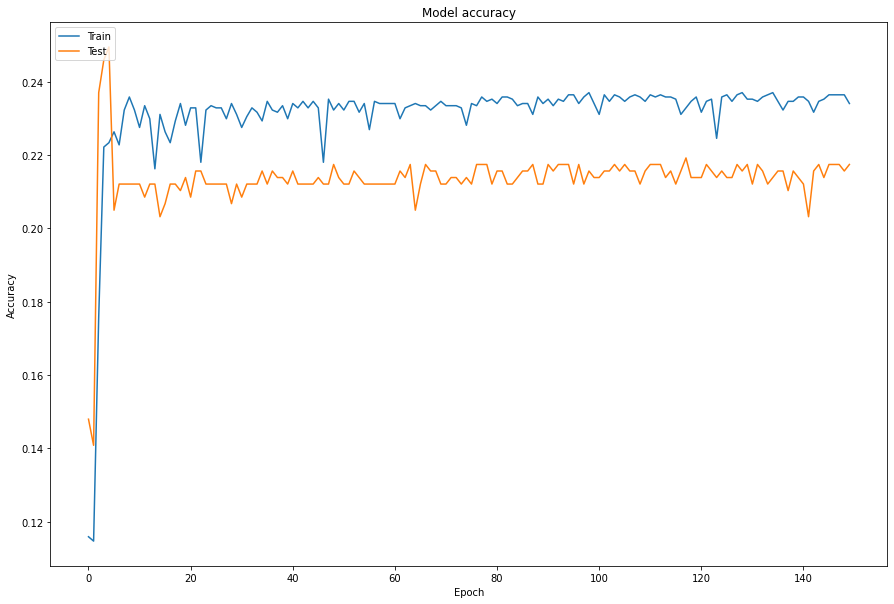

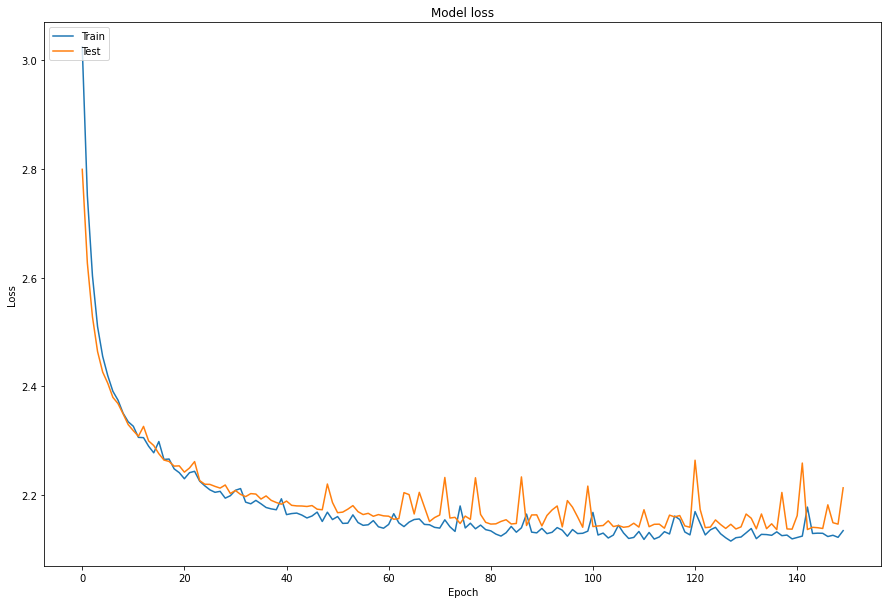

In [14]:
#                    Accuracy and Loss function
# ===========================================================================

display_accuracy()
display_loss()

In [15]:
model = Sequential()
model.add(Dense(10,activation='relu',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=150)

model.save_weights('sign_model.h5')

Epoch 1/150
53/53 [==============================] - 1s 12ms/step - loss: 104.0907 - accuracy: 0.0469 - val_loss: 49.3747 - val_accuracy: 0.0000e+00
Epoch 2/150
53/53 [==============================] - 0s 4ms/step - loss: 26.9856 - accuracy: 0.1224 - val_loss: 15.5125 - val_accuracy: 0.2353
Epoch 3/150
53/53 [==============================] - 0s 8ms/step - loss: 11.7305 - accuracy: 0.2359 - val_loss: 9.5298 - val_accuracy: 0.2032
Epoch 4/150
53/53 [==============================] - 0s 6ms/step - loss: 7.6055 - accuracy: 0.2810 - val_loss: 6.6727 - val_accuracy: 0.3137
Epoch 5/150
53/53 [==============================] - 0s 4ms/step - loss: 5.7547 - accuracy: 0.3678 - val_loss: 5.5417 - val_accuracy: 0.3476
Epoch 6/150
53/53 [==============================] - 0s 6ms/step - loss: 4.9813 - accuracy: 0.3731 - val_loss: 4.9019 - val_accuracy: 0.3529
Epoch 7/150
53/53 [==============================] - 0s 8ms/step - loss: 4.2500 - accuracy: 0.3922 - val_loss: 4.5911 - val_accuracy: 0.3102
Ep

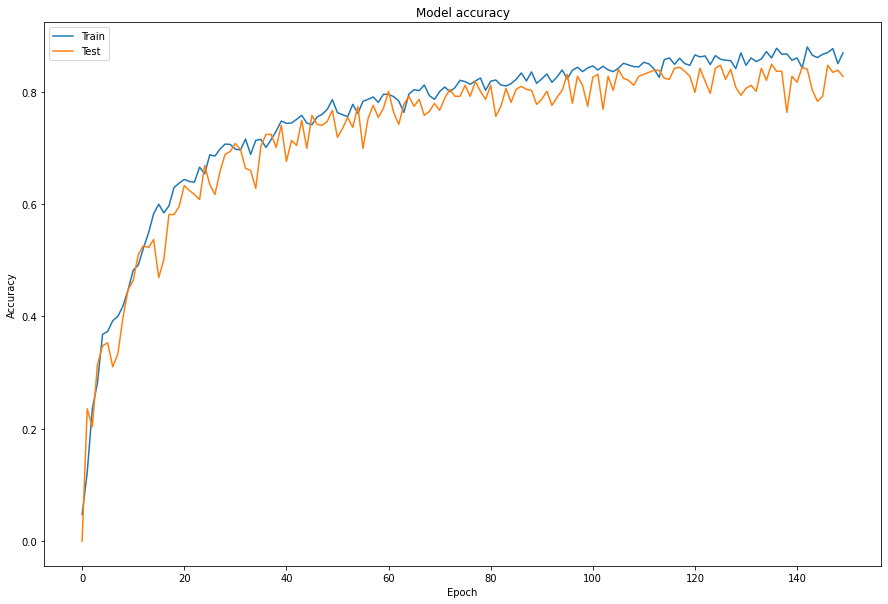

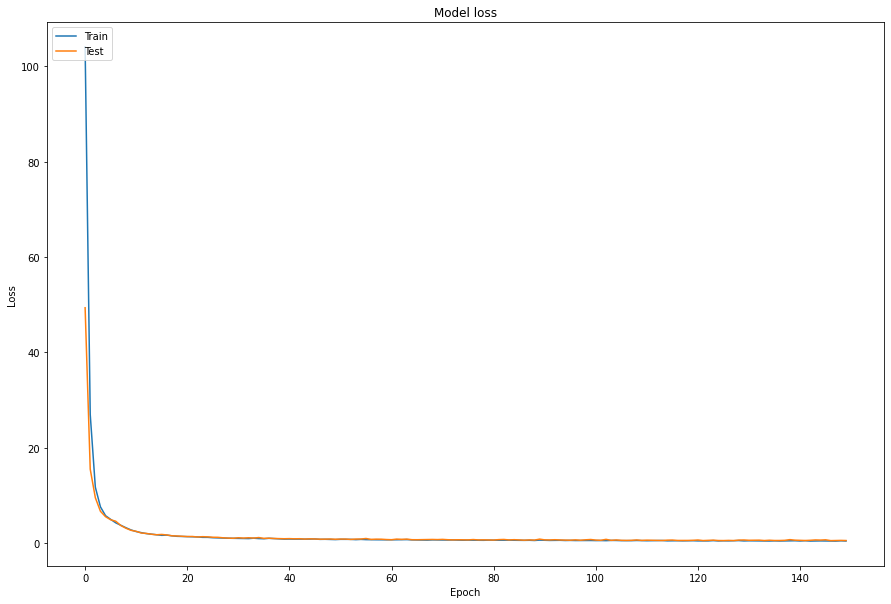

In [16]:
display_accuracy()
display_loss()

In [17]:
model = Sequential()
# model.add(GaussianNoise(0.15,input_shape=(144,),name="noise_layer"))
model.add(Dense(30,activation='relu',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=150)

model.save_weights('sign_model.h5')


Epoch 1/150
53/53 [==============================] - 1s 8ms/step - loss: 84.4316 - accuracy: 0.1355 - val_loss: 25.2381 - val_accuracy: 0.0927
Epoch 2/150
53/53 [==============================] - 0s 3ms/step - loss: 15.2499 - accuracy: 0.2341 - val_loss: 11.9320 - val_accuracy: 0.2353
Epoch 3/150
53/53 [==============================] - 0s 4ms/step - loss: 8.1100 - accuracy: 0.2698 - val_loss: 5.7377 - val_accuracy: 0.2745
Epoch 4/150
53/53 [==============================] - 0s 4ms/step - loss: 4.3094 - accuracy: 0.3904 - val_loss: 3.4437 - val_accuracy: 0.4403
Epoch 5/150
53/53 [==============================] - 0s 4ms/step - loss: 3.2321 - accuracy: 0.4742 - val_loss: 3.1108 - val_accuracy: 0.4902
Epoch 6/150
53/53 [==============================] - 0s 4ms/step - loss: 2.7552 - accuracy: 0.5098 - val_loss: 2.4653 - val_accuracy: 0.5437
Epoch 7/150
53/53 [==============================] - 0s 4ms/step - loss: 2.3729 - accuracy: 0.5490 - val_loss: 2.3943 - val_accuracy: 0.4635
Epoch 8/1

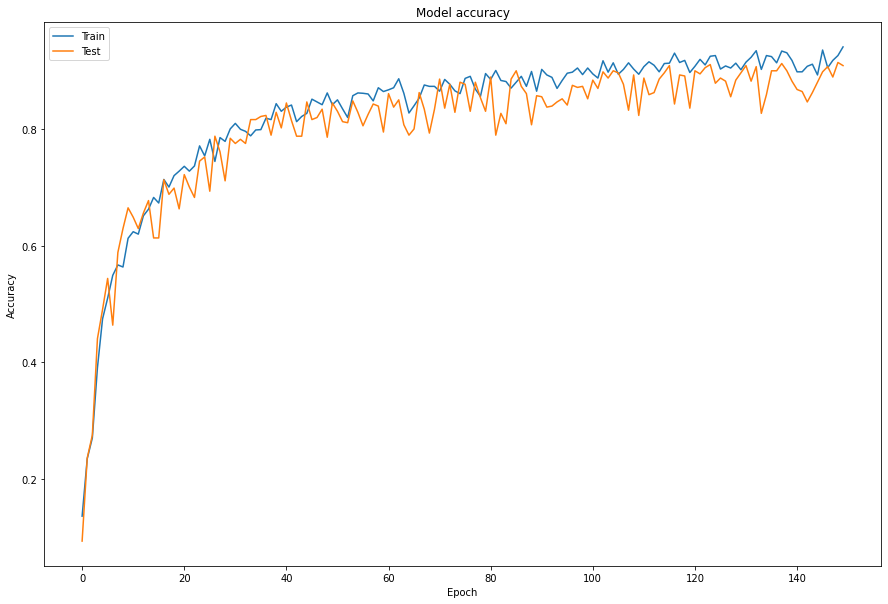

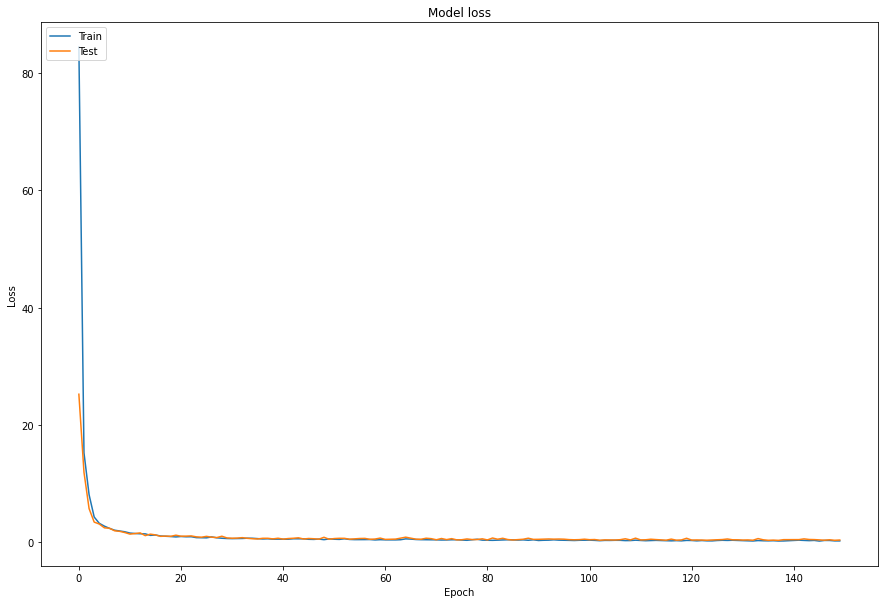

In [18]:
display_accuracy()
display_loss()

In [19]:
model = Sequential()
model.add(GaussianNoise(0.15,input_shape=(144,),name="noise_layer"))
model.add(Dense(30,activation='relu',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=150)

model.save_weights('sign_model.h5')

Epoch 1/150
53/53 [==============================] - 1s 8ms/step - loss: 115.6301 - accuracy: 0.0564 - val_loss: 61.5946 - val_accuracy: 0.0731
Epoch 2/150
53/53 [==============================] - 0s 4ms/step - loss: 31.8317 - accuracy: 0.0862 - val_loss: 14.1821 - val_accuracy: 0.1444
Epoch 3/150
53/53 [==============================] - 0s 5ms/step - loss: 8.7868 - accuracy: 0.2424 - val_loss: 5.7589 - val_accuracy: 0.3209
Epoch 4/150
53/53 [==============================] - 0s 4ms/step - loss: 4.5810 - accuracy: 0.3583 - val_loss: 3.9863 - val_accuracy: 0.3583
Epoch 5/150
53/53 [==============================] - 0s 6ms/step - loss: 3.4522 - accuracy: 0.4355 - val_loss: 3.3356 - val_accuracy: 0.4242
Epoch 6/150
53/53 [==============================] - 0s 5ms/step - loss: 2.9611 - accuracy: 0.4700 - val_loss: 2.8917 - val_accuracy: 0.4688
Epoch 7/150
53/53 [==============================] - 0s 5ms/step - loss: 2.6733 - accuracy: 0.4831 - val_loss: 2.6620 - val_accuracy: 0.5062
Epoch 8/

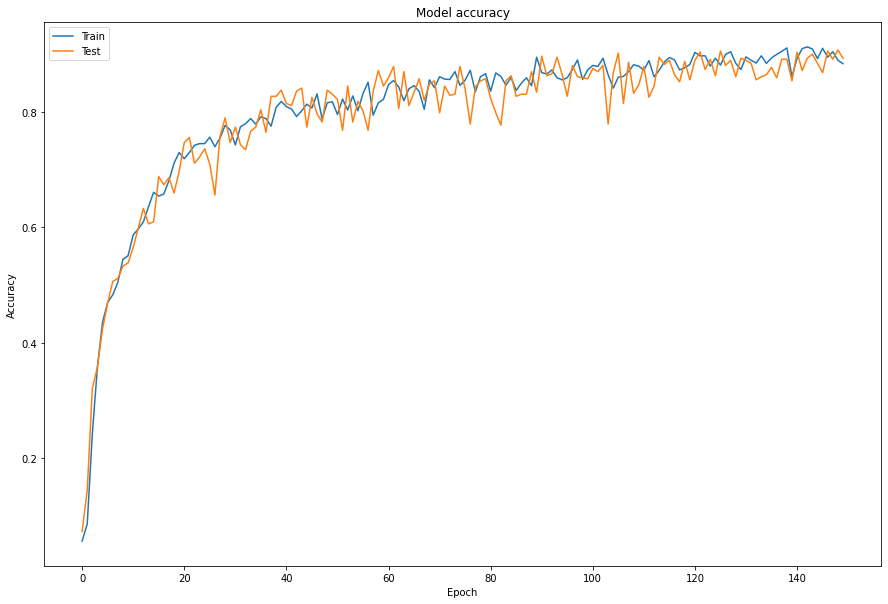

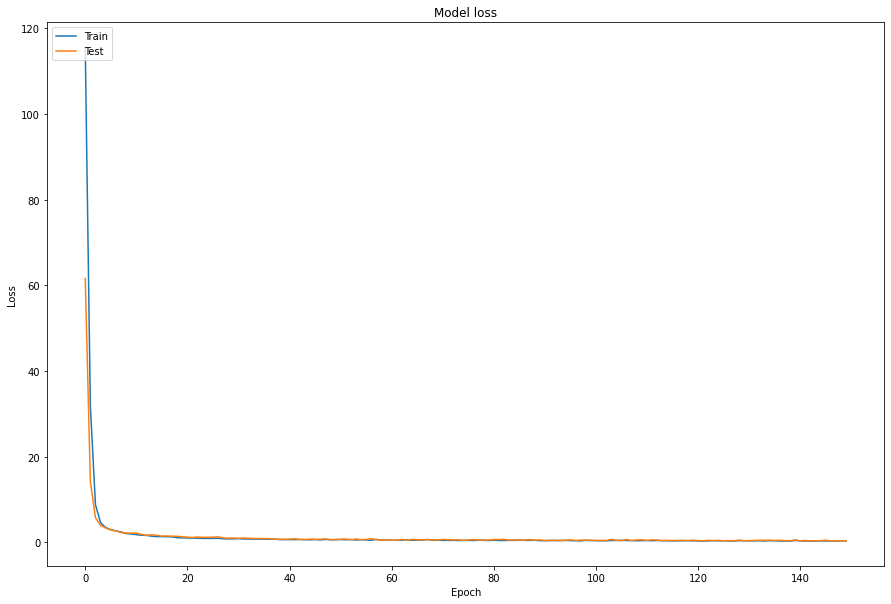

In [20]:
display_accuracy()
display_loss()

## Имитация переобучения

In [21]:
model = Sequential()
model.add(Dense(300,activation='relu',input_shape=(144,)))
model.add(Dense(300,activation='relu',))
model.add(Dense(300,activation='relu',))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=1500)

model.save_weights('sign_model.h5')

Epoch 1/1500
53/53 [==============================] - 2s 18ms/step - loss: 27.2366 - accuracy: 0.2620 - val_loss: 2.5353 - val_accuracy: 0.4973
Epoch 2/1500
53/53 [==============================] - 1s 14ms/step - loss: 2.8842 - accuracy: 0.4623 - val_loss: 4.5932 - val_accuracy: 0.3993
Epoch 3/1500
53/53 [==============================] - 1s 14ms/step - loss: 2.9721 - accuracy: 0.4854 - val_loss: 1.6991 - val_accuracy: 0.5847
Epoch 4/1500
53/53 [==============================] - 1s 14ms/step - loss: 1.6463 - accuracy: 0.5936 - val_loss: 1.2842 - val_accuracy: 0.6881
Epoch 5/1500
53/53 [==============================] - 1s 22ms/step - loss: 1.9099 - accuracy: 0.6191 - val_loss: 1.9702 - val_accuracy: 0.5205
Epoch 6/1500
53/53 [==============================] - 1s 24ms/step - loss: 1.4793 - accuracy: 0.6280 - val_loss: 1.1958 - val_accuracy: 0.6560
Epoch 7/1500
53/53 [==============================] - 2s 30ms/step - loss: 1.2129 - accuracy: 0.6667 - val_loss: 1.2408 - val_accuracy: 0.673

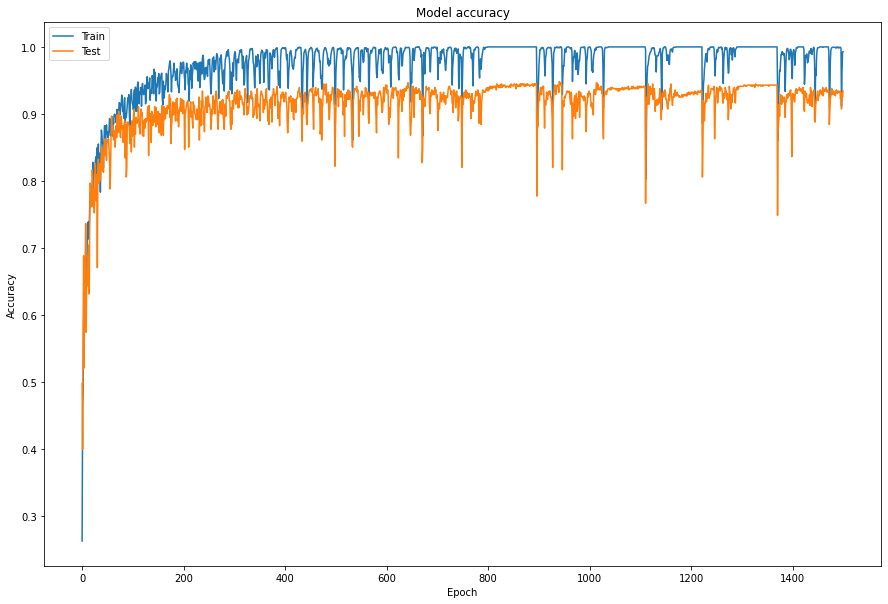

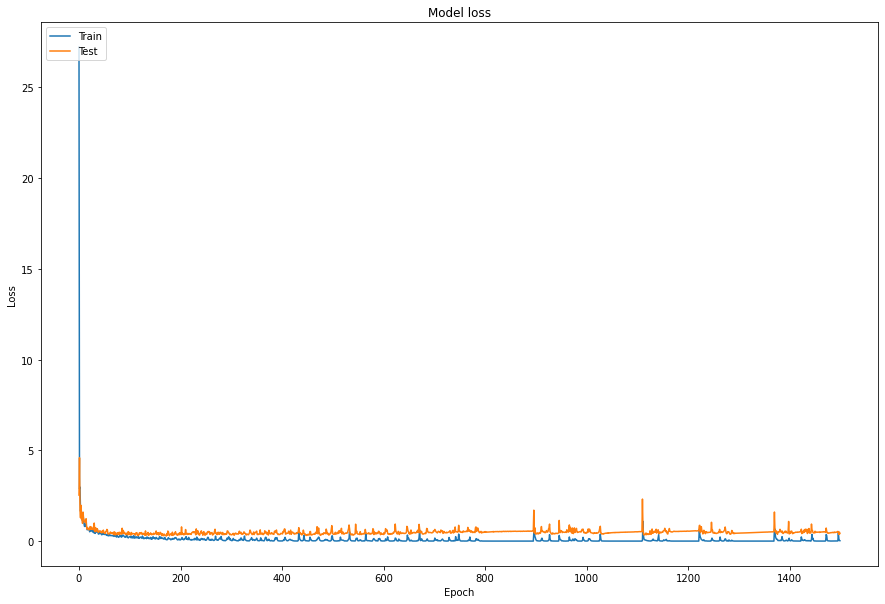

In [22]:
display_accuracy()
display_loss()


In [23]:
model = Sequential()
model.add(GaussianNoise(0.15,input_shape=(144,),name="noise_layer"))
model.add(Dense(30,activation='relu',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=150)

model.save_weights('sign_model.h5')

Epoch 1/150
53/53 [==============================] - 1s 8ms/step - loss: 195.0594 - accuracy: 0.0368 - val_loss: 84.8724 - val_accuracy: 0.0535
Epoch 2/150
53/53 [==============================] - 0s 5ms/step - loss: 41.0420 - accuracy: 0.0867 - val_loss: 15.6335 - val_accuracy: 0.1444
Epoch 3/150
53/53 [==============================] - 0s 5ms/step - loss: 10.0500 - accuracy: 0.2181 - val_loss: 7.3781 - val_accuracy: 0.2763
Epoch 4/150
53/53 [==============================] - 0s 5ms/step - loss: 5.4451 - accuracy: 0.2894 - val_loss: 4.3534 - val_accuracy: 0.2888
Epoch 5/150
53/53 [==============================] - 0s 5ms/step - loss: 3.9853 - accuracy: 0.3327 - val_loss: 3.6996 - val_accuracy: 0.3333
Epoch 6/150
53/53 [==============================] - 0s 5ms/step - loss: 3.3893 - accuracy: 0.3660 - val_loss: 3.1440 - val_accuracy: 0.3779
Epoch 7/150
53/53 [==============================] - 0s 5ms/step - loss: 3.0193 - accuracy: 0.4147 - val_loss: 2.7935 - val_accuracy: 0.4920
Epoch 8

In [24]:
import numpy as np
from scipy.optimize import minimize

Добавим функции:

1.   Функцию Interpany, которая будет интерпретировать возникающие при тестировании сети ошибки как ошибки первого или второго рода и возвращать кортеж из двух переменных с процентом возникновения данных ошибок соответственно.
2.   Функцию GetMistSum, которая возвращает сумму ошибок первого и второго при указанном приоритете ошибки второго рода.
3.   Функцию FindTh, которая находит и возвращает порог принятия решения, при котором функция GetMistSum минимальна.


In [26]:
def interpany(classouts,classets,classporog):
    classets = classets.applymap(bool)
    level = np.ones((classouts.shape[0],1))*classporog
    t2=classouts>level
    s1 = np.sum((t2==0)&classets)
    s2 = np.sum(t2&(~classets))
    ss1= np.sum(classets)
    p1=np.sum(s1)/np.sum(ss1)
    p2=np.sum(s2)/(t2.shape[0]*classets.shape[1]-np.sum(ss1))
    return np.array([p1,p2])
    
def GetMistSum(threahold, predc, truth, priority):
    first, second = interpany(predc, truth, threahold/100)
    return first + priority * second

def FindTh(predc, truth, priority):
    res = minimize(GetMistSum, 90, args=(predc, truth, priority),
                   method='powell',
                   options={'disp': True})
    return res.x / 100
target_df = feed_df.copy()

In [27]:
X = target_df.drop(columns='id_user')
Y = to_categorical(target_df['id_user'])
predc=pd.DataFrame(model.predict(X))
truth=pd.DataFrame(Y).applymap(round)
 
OptimalTh = FindTh(predc, truth, 10)
print("optimal threshold: ", OptimalTh)
 
first, second = interpany(predc, truth, OptimalTh)
print("first = ", first, " second = ", second)

71/71 [==============================] - 0s 3ms/step
Optimization terminated successfully.
         Current function value: 0.118660
         Iterations: 2
         Function evaluations: 76
optimal threshold:  [0.35353125]
first =  0.07085561497326204  second =  0.0047804245665208234


In [ ]:
#              tasks
# =================================================

1. Установлен сид = 777, архитектура сети без изменений
2. Убрать слой Dense - функция активации поменять на sigmoid
3. Изменение состояния модели - архитектура изменена. Количество эпох - 50. Функция оптимизации «Adamax», функция 
потерь как бинарная кроссэнтропия

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Epoch 1/50
53/53 [==============================] - 1s 8ms/step - loss: 0.6708 - accuracy: 0.0969 - val_loss: 0.6172 - val_accuracy: 0.0980
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 0.5751 - accuracy: 0.0969 - val_loss: 0.5318 - val_accuracy: 0.0980
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 0.4982 - accuracy: 0.0969 - val_loss: 0.4633 - val_accuracy: 0.0980
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 0.4365 - accuracy: 0.0969 - val_loss: 0.4084 - val_accuracy: 0.0980
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 0.3871 - accuracy: 0.0969 - val_loss: 0.3645 - val_accuracy: 0.0980
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 0.3475 - accuracy: 0.0969 - val_loss: 0.3292 - val_accuracy: 0.0980
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 0.3156 - accuracy: 0.0969 - val_loss: 0.3007 - val_accuracy: 0.0980
Epoch 8/50
53/53 [==

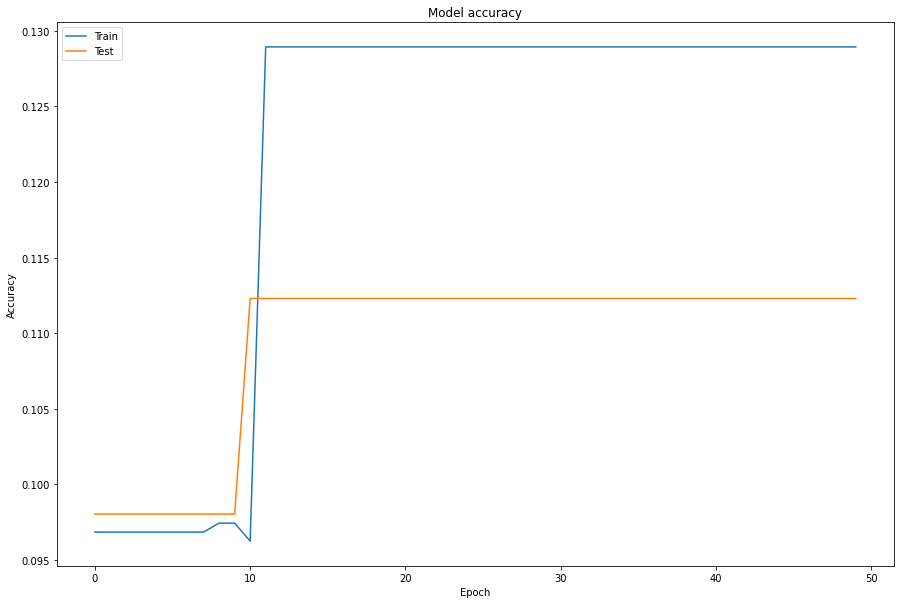

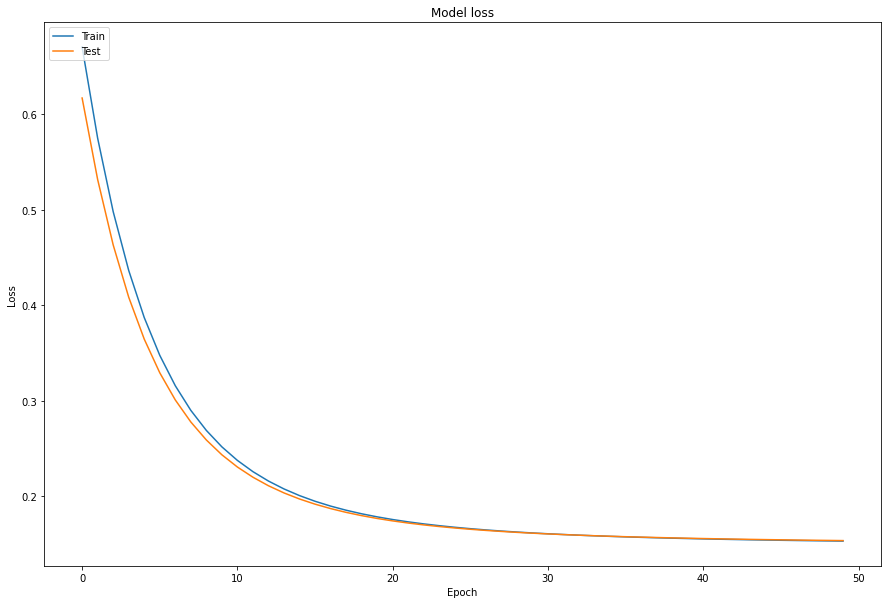

71/71 [==============================] - 0s 2ms/step
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 1
         Function evaluations: 13
optimal threshold:  [0.92587929]
first =  1.0  second =  0.0


In [28]:
import tensorflow as tf
import os
import random
import numpy as np
tf.keras.backend.set_floatx('float64')

friend_users = [1,8,9,10,11,14,15,17,18,19,20,22]
alien_users = [2,3,4,5,6,7,12,16,21]

friend_df = df[df['id_user'].isin(friend_users)]
alien_df  = df[df['id_user'].isin(alien_users)]

alien_df['id_user']=0 

feed_df=friend_df.merge(alien_df,how='outer')

X = feed_df.drop(columns='id_user')
Y = feed_df['id_user']

import pylab
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise

from tensorflow.keras.utils import to_categorical
dummy_y = to_categorical(Y)
from sklearn.model_selection import train_test_split

seed_value= 777
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

X_train,X_test,Y_train,Y_test = train_test_split(X,dummy_y)

'''
model = Sequential()
model.add(GaussianNoise(0.15,input_shape=(144,),name="noise_layer"))
model.add(Dense(30,activation='relu',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))
'''

model = Sequential()
model.add(GaussianNoise(stddev=0.2,input_shape=(144,),name="noise_layer"))
model.add(Dense(40,activation='relu',input_shape=(144,)))
model.add(Dense(10,activation='sigmoid',input_shape=(144,)))
model.add(Dense(dummy_y.shape[1],activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

results = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs=50)

model.save_weights('sign_model.h5')

def display_accuracy():
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def display_loss():
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

import numpy as np
from scipy.optimize import minimize

def interpany(classouts,classets,classporog):
    classets = classets.applymap(bool)
    level = np.ones((classouts.shape[0],1))*classporog
    t2=classouts>level
    s1 = np.sum((t2==0)&classets)
    s2 = np.sum(t2&(~classets))
    ss1= np.sum(classets)
    p1=np.sum(s1)/np.sum(ss1)
    p2=np.sum(s2)/(t2.shape[0]*classets.shape[1]-np.sum(ss1))
    return np.array([p1,p2])

def GetMistSum(threahold, predc, truth, priority):
    first, second = interpany(predc, truth, threahold/100)
    return first + priority * second

def FindTh(predc, truth, priority):
    res = minimize(fun=GetMistSum, x0=90, args=(predc, truth, priority),
                   method='powell', options={'disp': True})
    return res.x / 100

target_df = feed_df.copy()
 
X = target_df.drop(columns='id_user')
Y = to_categorical(target_df['id_user'])
predc=pd.DataFrame(model.predict(X))
truth=pd.DataFrame(Y).applymap(round)
 
OptimalTh = FindTh(predc, truth, 10)
print("optimal threshold: ", OptimalTh)
 
first, second = interpany(predc, truth, OptimalTh)
print("first = ", first, " second = ", second)